In [ ]:
! pip install ipywidgets
! jupyter nbextension enable --py widgetsnbextension

In [ ]:
from dloseg.models.sam2_class import SAM2Wrapper
import torch
import numpy as np
from sam2_realtime.sam2.build_sam import build_sam2
from sam2_realtime.sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt
import cv2
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation , 


processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipmodel = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
checkpoint_path = '/home/admina/segmetation/DLOSeg/src/sam2_realtime/checkpoints/sam2.1_hiera_large.pt'
model_cfg = 'configs/sam2.1/sam2.1_hiera_l.yaml'
device = None
if device is None:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")


sam2_model = build_sam2(model_cfg, checkpoint_path, device=device)
predictor = SAM2ImagePredictor(sam2_model,mask_threshold=0.0)
        

In [18]:
image_path = '/home/admina/segmetation/DLOSeg/src/dloseg/dataset/test_images/DepthViewer_Left_23135249_1242_10-03-2025-16-44-06.png'
# Load and process an image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the image
predictor.set_image(image)

In [19]:
prompts = ["a cabel."]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt",)
# predict
with torch.no_grad():
  outputs = clipmodel(output_hidden_states = True,output_attentions=True,**inputs)
preds = outputs.logits.unsqueeze(1)


In [246]:

outputs.decoder_output.hidden_states[2].shape

torch.Size([1, 485, 64])

Original mask shape: (352, 352)
Filtered mask shape: (352, 352)


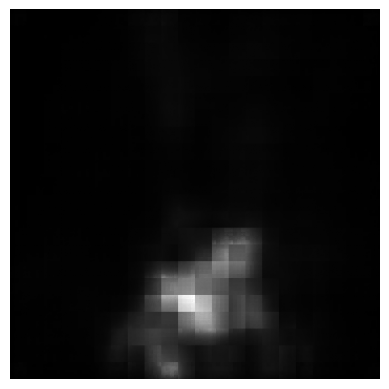

In [21]:
threshold = 0.0
mask = torch.sigmoid(preds).squeeze(0).squeeze(0).cpu().numpy()
print("Original mask shape:", mask.shape)

# Option 1: Get a 1D array of values above the threshold
filtered_values = mask[mask > threshold]
# print("Filtered values:", filtered_values)

# Option 2: Zero out values below the threshold while keeping the original shape
filtered_mask = mask * (mask > threshold)
print("Filtered mask shape:", filtered_mask.shape)

# Optionally plot the thresholded mask
plt.imshow(filtered_mask, cmap='gray')
plt.axis('off')
filtered_mask = torch.tensor(filtered_mask).to(device)

In [248]:
mask[mask > threshold]

array([1.1892704e-04, 1.3102555e-04, 1.1683932e-04, ..., 1.2378526e-04,
       1.1027974e-04, 7.8023113e-05], dtype=float32)

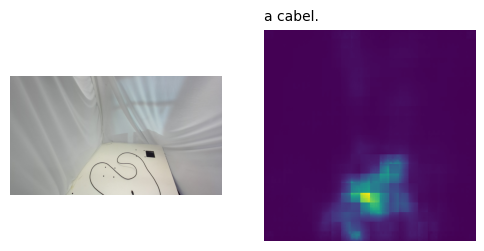

In [22]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [23]:
import torch.nn.functional as F


mask_resized = F.interpolate(
    filtered_mask.unsqueeze(0).unsqueeze(0),
    size=(256, 256),  # Correct resolution for SAM mask input
    mode='bilinear',
    align_corners=False
)

masks, iou_predictions, low_res_masks = predictor.predict(
    mask_input=mask_resized,
    
)

In [251]:
masks.shape

(3, 1242, 2208)

In [252]:
# 3 masks foreground/background/no-point
iou_predictions

array([0.00132207, 0.09029753, 0.44672257], dtype=float32)

In [253]:
low_res_masks.shape

(3, 256, 256)

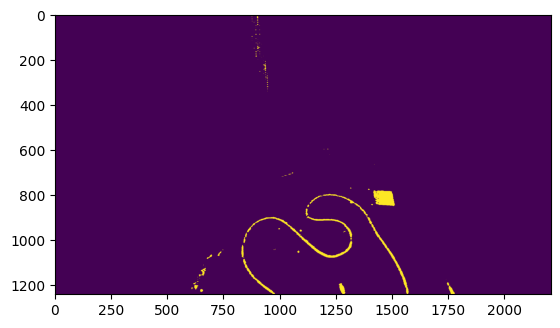

In [25]:
plt.imshow(masks[0])